**Overview**

In this example, we are going to use Open CV to detect the Lego piece.  The background of this data set is white, so the best place to test the approach is with a white piece.

**Setup**

We start by importing the libraries we need.  OpenCV imshow doesn't work in this notebook, so we'll need to use matplotlib.

In [51]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

listfiles=os.listdir("input")
print(listfiles)

['background_backlit_A.jpg', 'background_backlit_B.jpg', 'IMG_7960.jpg', 'real_image.jpg']


I want to show you what each image looks like after each step, so I am creating a function that will make it easy to preview each image as we go.

OpenCV uses BGR while matplotlib uses RGB, so we need to make sure that put these conversion in so the picture look accurate (you can try previewing without these if you like to test).

In [52]:
# Fonction de previsualisation d'image
def previewImg(text,img_preview,grayscale=False):
    if grayscale==False:
        # De BGR a RGB pour matplotlib
        plt.imshow(cv2.cvtColor(img_preview, cv2.COLOR_BGR2RGB))
    else:
        # Option pour les images en grayscale
        plt.imshow(cv2.cvtColor(img_preview, cv2.COLOR_GRAY2RGB))
    plt.title(text)
    plt.show()


Let's load the starting point.  The example image and it's background.

In [53]:
img_example=cv2.imread('input/IMG_7960.jpg')
img_bg=cv2.imread('input/background_backlit_B.jpg')

**Staring Point**

Visually this is our starting point (I'm using our defined function above).

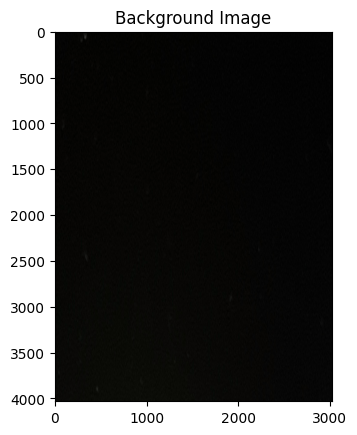

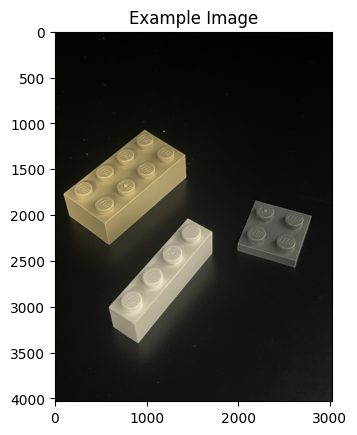

In [54]:
previewImg('Background Image',img_bg)
previewImg('Example Image',img_example)

**Step 1**

We know proceed to convert these images to Grayscale, and then preview them.

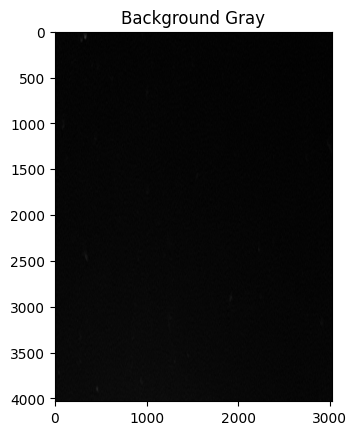

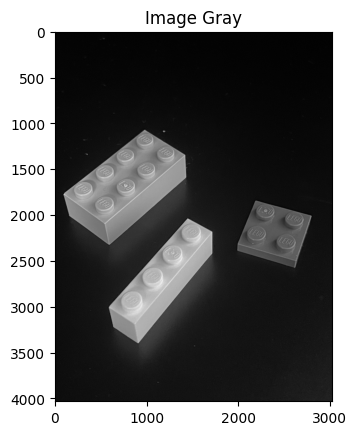

In [55]:
# Background - Gray
img_bg_gray=cv2.cvtColor(img_bg, cv2.COLOR_BGR2GRAY)
previewImg("Background Gray",img_bg_gray,True)

# Image - Gray
img_gray=cv2.cvtColor(img_example, cv2.COLOR_BGR2GRAY)
previewImg("Image Gray",img_gray,True)

**Step 2**

The background is the same in each images, so we will subtract the background from the base image to make sure the object is much more detectable.

The output is the "difference" between both images (you can play around and skipt his step).

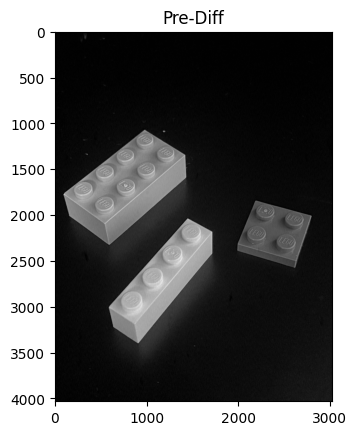

In [56]:
# Calculer la difference entre l'image et le background
diff_gray=cv2.absdiff(img_bg_gray,img_gray)
previewImg("Pre-Diff",diff_gray,True)

**Step 3**

Apply some Gaussian blur, which makes the image smoother between pixels (and helps us focus the detection on sharper contours).

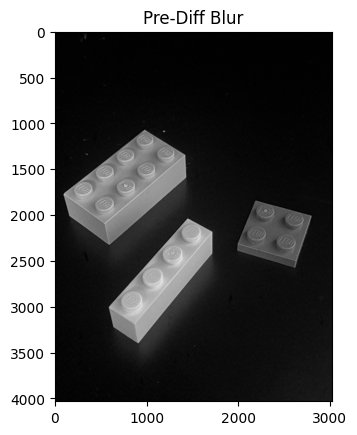

In [57]:
# Flou Gaussien
diff_gray_blur = cv2.GaussianBlur(diff_gray,(5,5),0)
previewImg("Pre-Diff Blur",diff_gray_blur,True)

**Step 4**

Now we apply Thresholding, which means that the algorithm will decide to placer pixels in either the background or foreground (binary).

We use the Otsu algorithm which iterates across the ideal values for this separation.

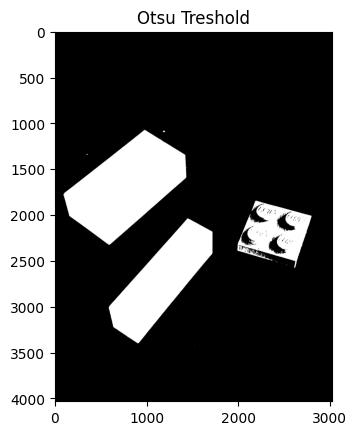

In [58]:
# Trouver le seuil optimal avec Otsu
ret, img_tresh = cv2.threshold(diff_gray_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
previewImg("Otsu Treshold",img_tresh,True)

**Step 5**

We use the image from Step 4 to detect the contour using OpenCV findContours function and draw them in green color.

We now have the contours, so we will draw them on top of the Original image.

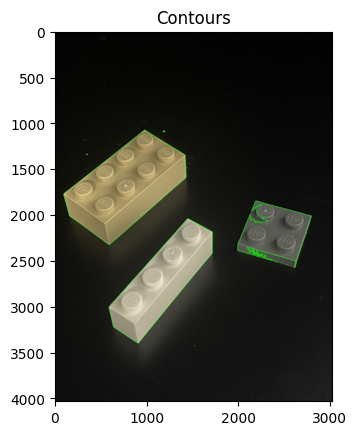

In [59]:
# Trouver les contours
arr_cnt, a2 = cv2.findContours(img_tresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Copier l'image pour ne pas modifier l'originale
img_with_allcontours = img_example.copy()

cv2.drawContours(img_with_allcontours, arr_cnt, -1, (0,255,0), 3)
previewImg('Contours',img_with_allcontours)

# !!! A ce stade, il est possible que nous ayons plus d'un contour, car il y a plusieurs objets dans l'image

**Optional Step**

It may be possible that we have more than one object/Lego piece in the picture or the algorithm is detecting some noise as contours.

This step here let's us eliminate these "noises".   The data set I'm running this Kernel on is cleaned, this would only apply to real case scenarios.

I run 3 conditions:
* minimum area to consider an object (e.g. anything smaller than a 1x1 brick I will consider noise).
* if the object is sitting in an edge (the brick is clipped)
* if the object has a ratio that exceeds the objects (in this case, the 1x6 plate is the thinnest piece to detect, anything with a longer ratio will be considered noise)

There is more than 1 object in the picture


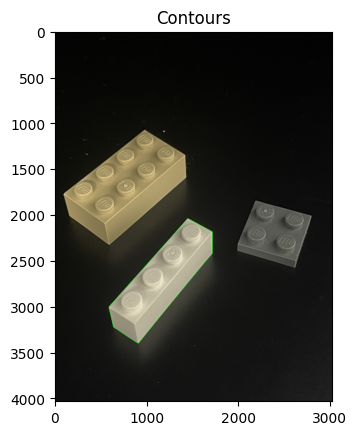

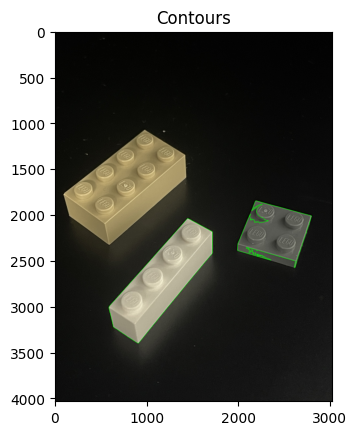

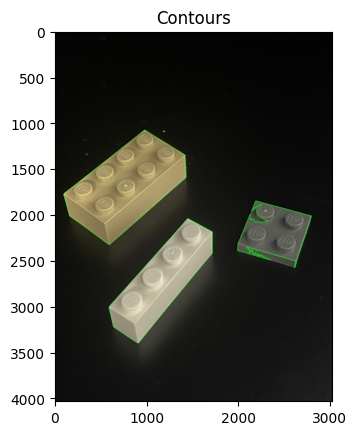

In [60]:
# Anecdotique : Nous devons filtrer l'image pour enlever le noise (les contours qui ne sont pas des legos)

# Dimensions de l'image
height, width, channels = img_example.shape

# Variable shortening
w=width
h=height

validcontours=[]
contour_index=-1

# Iterer sur chaque contour
for i in arr_cnt:

    contour_index=contour_index+1
    ca=cv2.contourArea(i)

    # Calcul du ratio W/H
    x,y,w,h = cv2.boundingRect(i)
    aspect_ratio = float(w)/h

    # Flag en tant que bruit si le contour est sur le bord de l'image
    # Les contours qui sont sur le bord de l'image sont generalement du bruit
    edge_noise=False
    if x==0:
        edge_noise=True
    if y==0:
        edge_noise=True
    # Si l'objet est sur le bord de l'image, on le considere comme du bruit
    if (x+w)==width:
        edge_noise=True
    if (y+h)==height:
        edge_noise=True
            
    # SUPPRIMER si l'aire est trop petite
    if ca>1300:
        if aspect_ratio<=6:
            # SUPPRIMER si le contour est sur le bord de l'image
            if edge_noise==False:
                validcontours.append(contour_index)

# Copier l'image originale
img_withcontours=img_example.copy()
                
# Afficher le nombre de contours valides
if len(validcontours)>1:
    print("There is more than 1 object in the picture")
else:
    if len(validcontours)==1:
        print("One object detected")
    else:
        print("No objects detected")
      
for i in validcontours:
    cv2.drawContours(img_withcontours, arr_cnt, i, (0,255,0), 3)
    previewImg('Contours',img_withcontours)



**Optional Step**

If you need to crop the image, it will be useful to be able to identify a rectangle.

To achieve this, use OpenCV bounding rectangle function.

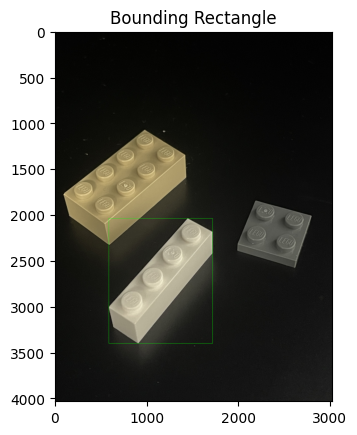

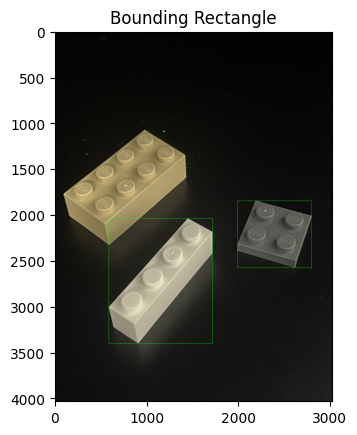

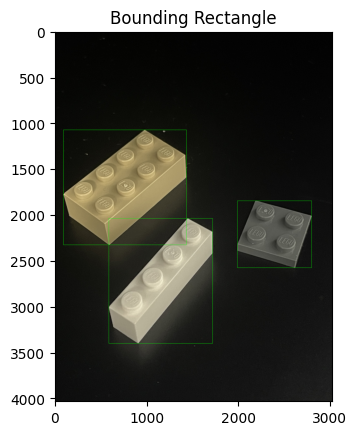

In [61]:
# Afficher une bounding box
img_withrectangle=img_example.copy()
for i in validcontours:
    x,y,w,h = cv2.boundingRect(arr_cnt[i])
    cv2.rectangle(img_withrectangle,(x,y),(x+w,y+h),(0,255,0),2)
    previewImg('Bounding Rectangle',img_withrectangle)

### Sauvegarder chaque Lego en tant qu'image individuelle

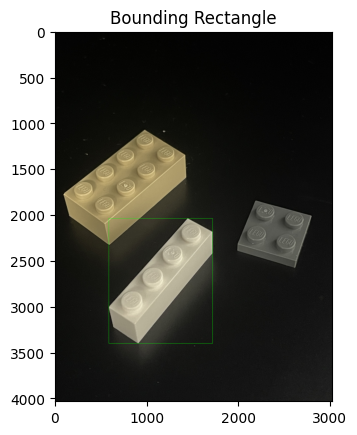

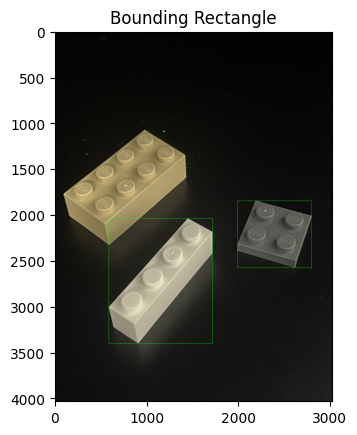

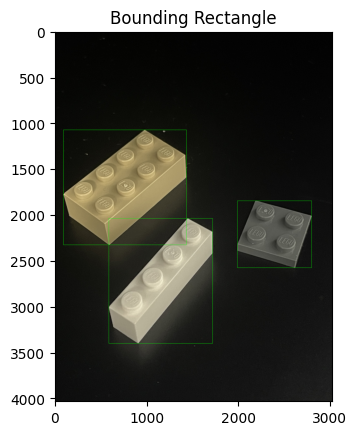

In [62]:
img_withrectangle=img_example.copy()

# Check output folder
if not os.path.exists('output'):
    os.makedirs('output')

# Iterer sur chaque contour
for i in validcontours:
    x,y,w,h = cv2.boundingRect(arr_cnt[i])
    cv2.rectangle(img_withrectangle,(x,y),(x+w,y+h),(0,255,0),2)
    
    # Crop image
    crop_img = img_example[y:y+h, x:x+w]
    
    # Sauvegarder l'image
    cv2.imwrite("output/crop_"+str(i)+".jpg", crop_img)
    previewImg('Bounding Rectangle',img_withrectangle)